In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

In [3]:
def TMM_IndexStep_Matrix(n1,n2):
    '''Calculate the transfer matrix for a index step from n1 to n2.'''
   
    root = (2*np.sqrt(n1*n2))
    a    = (n1+n2)/root;
    b    = (n1-n2)/root;
    
    T_is = np.zeros((2,2,len(n1))) 
    T_is[0,0,:] = a; T_is[0,1,:] = b;
    T_is[1,0,:] = b; T_is[1,1,:] = a
    
    return T_is

def TMM_HomoWG_Matrix(wl_nm,l_nm,n_eff,loss):
    ''' Calculate the transfer matrix of a homogeneous waveguide. '''

    beta  = 2*np.pi*n_eff/wl_nm-1j*loss/2
    
    T_hw  = np.zeros((2,2,len(n_eff)),dtype=complex)
    T_hw[0,0,:] = np.exp(1j*beta*l_nm)
    T_hw[1,1,:] = np.exp(-1j*beta*l_nm)
    
    return T_hw

def TMM_Grating_Matrix(wl_nm, period_nm, NG, n1, n2, loss):
    '''Calculate the total transfer matrix of the gratings'''
    
    l_nm   =  period_nm/2;
    T_hw1  = TMM_HomoWG_Matrix(wl_nm,l_nm,n1,loss);
    T_is12 = TMM_IndexStep_Matrix(n1,n2);
    T_hw2  = TMM_HomoWG_Matrix(wl_nm,l_nm,n2,loss);
    T_is21 = TMM_IndexStep_Matrix(n2,n1);  
    
    q  = len(wl_nm);
    Tp = np.zeros((2,2,q),dtype=complex); 
    T = np.zeros((2,2,q),dtype=complex);
                                                       
    
    for i in range(len(wl_nm)):
        Tp[:,:,i] = T_hw2[:,:,i]@T_is21[:,:,i]@T_hw1[:,:,i]@T_is12[:,:,i];
        T[:,:,i]  = np.linalg.matrix_power(Tp[:,:,i], NG); # 1st order uniform Bragg grating
        
        #for an FP cavity, 1st order cavity, insert a high index region, n2.
        #T[:,:,i] = Tp[:,:,i]**NG * (T_hw2[:,:,i]) * Tp[:,:,i]**NG * T_hw2[:,:,i];

    return T

def TMM_Grating_RT(wl_nm, period_nm, NG, n1, n2, loss):
    '''Calculate the R and T versus wavelength'''

    M = TMM_Grating_Matrix(wl_nm, period_nm, NG, n1, n2, loss);   
    q = len(wl_nm)-1;     
    T = np.abs(1/M[0,0,:])**2;  
    R = np.abs(M[1,0,:]/M[0,0,:])**2;
  
    return [R,T]

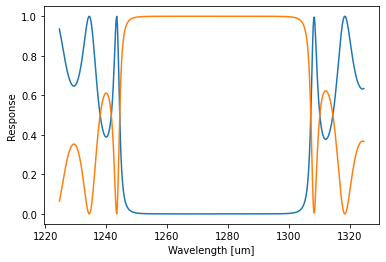

In [4]:
# def gratingReflectivity():
#     '''This is used to plot the reflection/transmission spectrum.'''

#Grating Parameters
period_nm = 300          # Bragg period
NG        = 50          # Number of grating periods
l_nm      = NG*period_nm    # Grating length
width0_nm = 300;         # mean waveguide width
dwidth_nm = 25;        # +/- waveguide width
width1    = width0_nm - dwidth_nm;
width2    = width0_nm + dwidth_nm;
loss_dBcm = 4e-4;           # waveguide loss, dB/cm
loss      = 0.1*np.log(10)*loss_dBcm*(1e2)*(1e-9) #1/nm

#Simulation Parameters:
span_nm   = 100;       # Set the wavelength span for the simultion
Npoints   = 500;

# from book: Strip waveguide; 500x220 nm
def neff_wavelength(wl_nm):
    return  2.4379 - 1.1193*(1e-3)*(wl_nm-1554) - 0.035*(1e-6)*(wl_nm-1554)**2;

def dneff_width(w):
    return 10.4285*(1e-9)*(w-500)**3 - 5.2487*(1e-6)*(w-500)**2 + 1.6142*(1e-3)*(w-500);

# Find Bragg wavelength using lambda_Bragg = Period * 2neff(lambda_bragg);
# Assume neff is for the average waveguide width.

def func(lambda_nm):
    n_avg = neff_wavelength(lambda_nm)
    n_avg += (dneff_width(width2)+dneff_width(width1))/2
    return lambda_nm - period_nm*2*n_avg;

wavelength0 = fsolve(func,1300)


wavelengths = wavelength0 + np.linspace(-span_nm/2, span_nm/2, Npoints);
n1    = neff_wavelength(wavelengths)+dneff_width(width1); # low index
n2    = neff_wavelength(wavelengths)+dneff_width(width2); # high index

#print(wavelength0,n1[:3],n2[:3])
      
[R,T] = TMM_Grating_RT(wavelengths, period_nm, NG, n1, n2, loss)

plt.figure()
plt.plot(wavelengths,T)
plt.plot(wavelengths,R)
plt.xlabel("Wavelength [um]")
plt.ylabel("Response")
plt.show()


## fitting COMSOL data

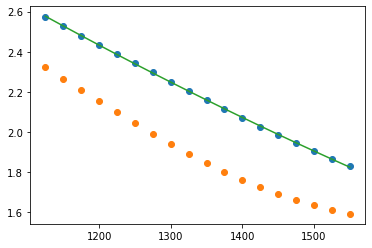

In [5]:
file = open('nk_wl2.dat')
lst = []
for line in file:
    lst += [line.split()]
    
data      = np.array(lst[6:],dtype=float)
wl_nm     = data[:,0]
n_TE      = data[:,3]
n_TM      = data[:,1]
params_wl = np.polyfit((wl_nm-1280),n_TE,2)
p_wl      = np.poly1d(params_wl)

plt.plot(wl_nm, n_TE, marker = 'o', linestyle = '')
plt.plot(wl_nm, n_TM, marker = 'o', linestyle = '')
plt.plot(wl_nm, p_wl(wl_nm-1280))
plt.show()


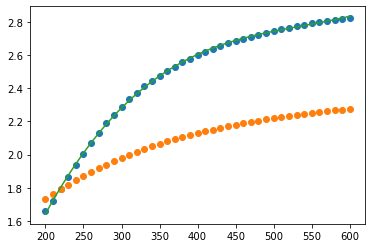

In [6]:
file = open('nk_w2.dat')
lst = []
for line in file:
    lst += [line.split()]
    
data = np.array(lst[5:],dtype=float)

w = data[:,0]

w_degen = 220 #assuming data is sorted. 
#probably more rigorous to redo comparison with e.g. data[:,1] < data[:,3]
n_TE    = np.hstack((data[:,1][w < w_degen],data[:,3][w >= w_degen]))
n_TM    = np.hstack((data[:,3][w < w_degen],data[:,1][w >= w_degen]))

params_w = np.polyfit(w-300,n_TE,3)
p_w      = np.poly1d(params_w)

plt.figure()
plt.plot(w, n_TE, marker = 'o', linestyle = '')
plt.plot(w, n_TM, marker = 'o', linestyle = '')
plt.plot(w, p_w(w-300))
plt.show()

[1226.07045439] [1.84604056 1.84525934 1.84447826] [2.76311131 2.76233009 2.76154901]


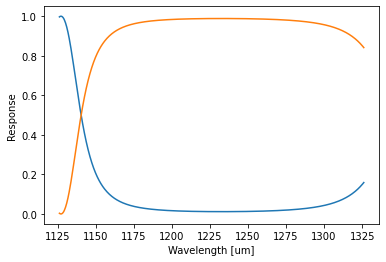

In [7]:
# def gratingReflectivity():
#     '''This is used to plot the reflection/transmission spectrum.'''

#Grating Parameters
period_nm = 290          # Bragg period
NG        = 7          # Number of grating periods
l_nm      = NG*period_nm    # Grating length
width0_nm = 270;         # mean waveguide width
dwidth_nm = 80;        # +/- waveguide width
width1    = width0_nm - dwidth_nm;
width2    = width0_nm + dwidth_nm;
loss_dBcm = 0;           # waveguide loss, dB/cm
loss      = 0.1*np.log(10)*loss_dBcm*(1e2)*(1e-9) #1/nm

#Simulation Parameters:
span_nm   = 200;       # Set the wavelength span for the simultion
Npoints   = 500;

def neff_wavelength(wl_nm,flag = 0):
    if flag:
        return  2.4379 - 1.1193*(1e-3)*(wl_nm-1554) - 0.035*(1e-6)*(wl_nm-1554)**2;
    else:
        return p_wl(wl_nm-1280)
    
def dneff_width(w_nm,flag = 0):
    if flag:
        return 10.4285*(1e-9)*(w_nm-500)**3 - 5.2487*(1e-6)*(w_nm-500)**2 + 1.6142*(1e-3)*(w_nm-500);
    else:
        return p_w(w_nm-300)-p_wl(0)

# Find Bragg wavelength using lambda_Bragg = Period * 2neff(lambda_bragg);
# Assume neff is for the average waveguide width.

def func(lambda_nm):
    n_avg = neff_wavelength(lambda_nm)
    n_avg += (dneff_width(width2)+dneff_width(width1))/2
    return lambda_nm - period_nm*2*n_avg;

wavelength0 = fsolve(func,1300)

wavelengths = wavelength0 + np.linspace(-span_nm/2, span_nm/2, Npoints);
n1    = neff_wavelength(wavelengths)+dneff_width(width1); # low index
n2    = neff_wavelength(wavelengths)+dneff_width(width2); # high index

print(wavelength0,n1[:3],n2[:3])
      
[R,T] = TMM_Grating_RT(wavelengths, period_nm, NG, n1, n2, loss)

plt.figure()
plt.plot(wavelengths,T)
plt.plot(wavelengths,R)
plt.xlabel("Wavelength [um]")
plt.ylabel("Response")
plt.show()


In [8]:
def neff_wavelength(wl_nm,flag = 0):
    if flag:
        return  2.4379 - 1.1193*(1e-3)*(wl_nm-1554) - 0.035*(1e-6)*(wl_nm-1554)**2;
    else:
        return p_wl(wl_nm-1280)
    
def dneff_width(w_nm,flag = 0):
    if flag:
        return 10.4285*(1e-9)*(w_nm-500)**3 - 5.2487*(1e-6)*(w_nm-500)**2 + 1.6142*(1e-3)*(w_nm-500);
    else:
        return p_w(w_nm-300)-p_wl(0)





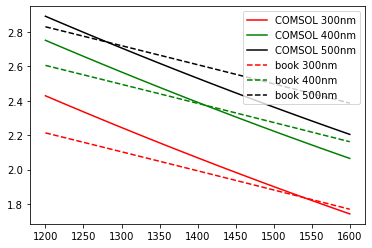

In [9]:
colors = ['r','g','k'];
lines = ['-','--']
sources = ['COMSOL','book']
widths = [300,400,500]

wl_wide = np.linspace(1200,1600,100)

for flag in [0,1]:
    for i in range(3):
        nplot = neff_wavelength(wl_wide,flag) + dneff_width(widths[i],flag)
        plt.plot(wl_wide,nplot, 
                 color = colors[i], 
                label = sources[flag] + ' '+ str(widths[i]) + 'nm',
                 linestyle = lines[flag])
plt.legend()

[1282.82112071] [1.98252786 1.98176606 1.98100441] [2.46154937 2.46078757 2.46002591]


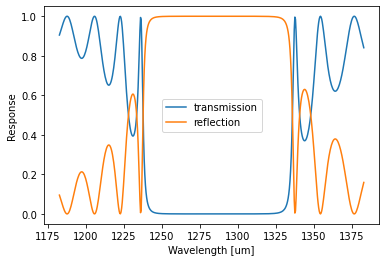

In [10]:
# def gratingReflectivity():
#     '''This is used to plot the reflection/transmission spectrum.'''

#Grating Parameters
period_nm = 315          # Bragg period
NG        = 25          # Number of grating periods
l_nm      = NG*period_nm    # Grating length
width0_nm = 260;         # mean waveguide width
dwidth_nm = 40;        # +/- waveguide width
width1    = width0_nm - dwidth_nm;
width2    = width0_nm + dwidth_nm;
loss_dBcm = 0;           # waveguide loss, dB/cm
loss      = 0.1*np.log(10)*loss_dBcm*(1e2)*(1e-9) #1/nm

#Simulation Parameters:
span_nm   = 200;       # Set the wavelength span for the simultion
Npoints   = 500;

def neff_wavelength(wl_nm,flag = 0):
    if flag:
        return  2.4379 - 1.1193*(1e-3)*(wl_nm-1554) - 0.035*(1e-6)*(wl_nm-1554)**2;
    else:
        return p_wl(wl_nm-1280)
    
def dneff_width(w_nm,flag = 0):
    if flag:
        return 10.4285*(1e-9)*(w_nm-500)**3 - 5.2487*(1e-6)*(w_nm-500)**2 + 1.6142*(1e-3)*(w_nm-500);
    else:
        return p_w(w_nm-300)-p_wl(0)

# Find Bragg wavelength using lambda_Bragg = Period * 2neff(lambda_bragg);
# Assume neff is for the average waveguide width.

def func(lambda_nm):
    n_avg = neff_wavelength(lambda_nm)
    n_avg += (dneff_width(width2)+dneff_width(width1))/2
    return lambda_nm - period_nm*2*n_avg;

wavelength0 = fsolve(func,1300)

wavelengths = wavelength0 + np.linspace(-span_nm/2, span_nm/2, Npoints);
n1    = neff_wavelength(wavelengths)+dneff_width(width1); # low index
n2    = neff_wavelength(wavelengths)+dneff_width(width2); # high index

print(wavelength0,n1[:3],n2[:3])
      
[R,T] = TMM_Grating_RT(wavelengths, period_nm, NG, n1, n2, loss)

plt.figure()
plt.plot(wavelengths,T,label = "transmission")
plt.plot(wavelengths,R,label = "reflection")
plt.xlabel("Wavelength [um]")
plt.ylabel("Response")
plt.legend()
plt.show()


In [11]:
def plotwindow(wavelengths, R, T):
    plt.figure()
    plt.plot(wavelengths,T,label = "transmission")
    plt.plot(wavelengths,R,label = "reflection")
    plt.xlabel("Wavelength [um]")
    plt.ylabel("Response")
    plt.legend()
    plt.show()

def func(lambda_nm):
    n_avg = neff_wavelength(lambda_nm)
    n_avg += (dneff_width(width2)+dneff_width(width1))/2
    return lambda_nm - period_nm*2*n_avg;

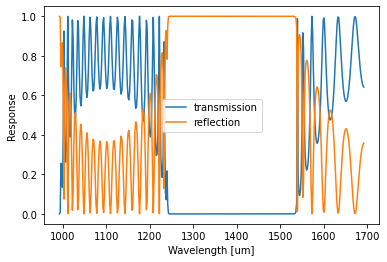

In [35]:
# def gratingReflectivity():
#     '''This is used to plot the reflection/transmission spectrum.'''

#Grating Parameters
period_nm = 370          # Bragg period
NG        = 20          # Number of grating periods
l_nm      = NG*period_nm    # Grating length
width0_nm = 300;         # mean waveguide width
dwidth_nm = 150;        # +/- waveguide width
width1    = width0_nm - dwidth_nm;
width2    = width0_nm + dwidth_nm;
loss_dBcm = 0;           # waveguide loss, dB/cm
loss      = 0.1*np.log(10)*loss_dBcm*(1e2)*(1e-9) #1/nm

#Simulation Parameters:a
span_nm   = 700;      
Npoints   = 400;

wavelength0 = fsolve(func,1450)

wavelengths = wavelength0 + np.linspace(-span_nm/2, span_nm/2, Npoints);
n1    = neff_wavelength(wavelengths)+dneff_width(width1); # low index
n2    = neff_wavelength(wavelengths)+dneff_width(width2); # high index
      
[R,T] = TMM_Grating_RT(wavelengths, period_nm, NG, n1, n2, loss)

plotwindow(wavelengths, R, T)

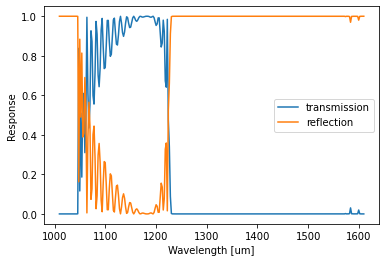

In [25]:
# def gratingReflectivity():
#     '''This is used to plot the reflection/transmission spectrum.'''

#Grating Parameters
period_nm = 480          # Bragg period
NG        = 20          # Number of grating periods
l_nm      = NG*period_nm    # Grating length
# width0_nm = 260;         # mean waveguide width
# dwidth_nm = 80;        # +/- waveguide width
width1    = 300 #width0_nm - dwidth_nm; #narrow
width2    = 100 #width0_nm + dwidth_nm; #wide
loss_dBcm = 0;           # waveguide loss, dB/cm
loss      = 0.1*np.log(10)*loss_dBcm*(1e2)*(1e-9) #1/nm

#Simulation Parameters:a
span_nm   = 600;      
Npoints   = 300;

wavelength0 = fsolve(func,1450)

wavelengths = wavelength0 + np.linspace(-span_nm/2, span_nm/2, Npoints);
n1    = neff_wavelength(wavelengths)+dneff_width(width1); # low index
n2    = neff_wavelength(wavelengths)+dneff_width(width2); # high index
      
[R,T] = TMM_Grating_RT(wavelengths, period_nm, NG, n1, n2, loss)

plotwindow(wavelengths, R, T)